In [1]:
import numpy as np
np.random.seed(1337)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
import pickle
import plotting
import matplotlib.pyplot as plt
import cv2
import math
from pylab import rcParams
import scipy
rcParams['figure.figsize'] = 10, 10
%matplotlib inline
from skimage import color
from skimage.filters.rank import entropy
from skimage.morphology import disk
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import pandas as pd
from skimage.filters.rank import entropy
from skimage.morphology import disk, square
from PIL import Image
import satfunctions

%load_ext autoreload
%autoreload 2

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X = []
y = []
for i in range(12):
    sat_img = cv2.imread('TOLABEL16/original/{}.jpeg'.format(i), cv2.IMREAD_COLOR)
    label_img = cv2.imread('TOLABEL16/labels/{}.jpg'.format(i), cv2.IMREAD_GRAYSCALE)
    preprocessed_sat_img = satfunctions.preprocess(sat_img)

    X.extend(preprocessed_sat_img)
    y.extend((label_img // 255).flatten())

for i in range(3):
    sat_img = cv2.imread('TOLABELWATER/original/{}.jpeg'.format(i), cv2.IMREAD_COLOR)
    label_img = cv2.imread('TOLABELWATER/labels/{}.jpg'.format(i), cv2.IMREAD_GRAYSCALE)
    preprocessed_sat_img = satfunctions.preprocess(sat_img)

    X.extend(preprocessed_sat_img)
    y.extend((label_img // 255).flatten())

C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:18: RuntimeWarning: divide by zero encountered in log
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:18: RuntimeWarning: invalid value encountered in subtract
  alpha * np.log(img[:, :, 2] / float(255)) -
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:19: RuntimeWarning: divide by zero encountered in log
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:19: RuntimeWarning: invalid value encountered in subtract
  (1 - alpha) * np.log(img[:, :, 0] / float(255)))
c:\program files\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\serge\Documents\EPFL\Personal Interaction Studio\Code\satfunctions.py:102

In [3]:
y = np.array(y)
X = np.array(X)
# Balance groups
to_keep_pos = np.where(y == 1)[0]
all_neg = np.where(y == 0)[0]
to_keep_neg = np.random.permutation(all_neg)[:len(to_keep_pos)]
to_keep = np.concatenate((to_keep_pos, to_keep_neg))

y = y[to_keep]
X = X[to_keep]
print(len(y))
print(len(X))

768622
768622


In [4]:
print(X[0].shape)

(10,)


In [5]:
print(len(X))
print(len(y))
pickle.dump({'X': X, 'y': y}, open('ManuallyTrained512x512Data.p', 'wb'))

768622
768622


In [3]:
import_data = pickle.load(open('ManuallyTrained512x512DataLess.p', 'rb'))
X = import_data['X']
y = import_data['y']

In [4]:
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

# X_pd = pd.DataFrame(X)
# X_pd.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_pd.fillna(0, inplace=True)

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
print(cross_val_score(bdt, X, y, cv=cv, verbose=10, n_jobs=8))

[0.90436021 0.9063581  0.90705182]


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   39.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   39.6s finished


In [5]:
bdt.fit(X, y)
print('Model fitted!')

Model fitted!


In [6]:
pickle.dump(bdt, open('TrainedModelManualZoom16Less.p', 'wb'))

In [2]:
bdt = pickle.load(open('TrainedModelManualZoom16.p', 'rb'))

In [20]:
bdt.feature_importances_

array([0.20563336, 0.1757775 , 0.26775501, 0.0140876 , 0.01863016,
       0.01131526, 0.02986354, 0.01367047, 0.00933586, 0.25393123])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


--- Elapsed 3.0522494794306567 seconds ---
--- Total 7.047845699969685 seconds ---
Predicted!


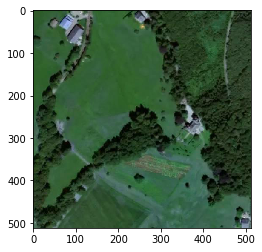

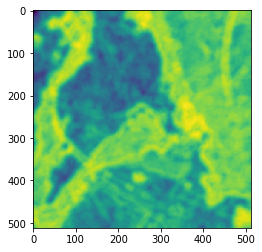

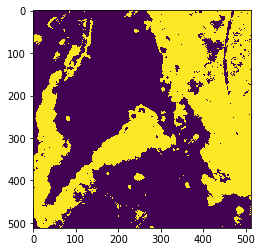

In [26]:
start_time = time.clock()

def test_image(img):
    features = satfunctions.preprocess_img(img)
    return features
test_img = cv2.imread('TOLABEL16/original/15.jpeg', cv2.IMREAD_COLOR)
preprocessed_test_img = test_image(test_img)

print("--- Elapsed %s seconds ---" % (time.clock() - start_time))

predicted_test_img = bdt.predict(preprocessed_test_img)

print("--- Total %s seconds ---" % (time.clock() - start_time))

plt.figure()
plt.imshow(test_img)
plt.figure()
plt.imshow(entropy(color.rgb2lab(test_img)[:,:,0] / 100, disk(11)))
plt.figure()
plt.imshow(predicted_test_img.reshape(512, 512))
print('Predicted!')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


--- Elapsed 1.1623359431696372 seconds ---
--- Total 5.081550877218433 seconds ---
Predicted!


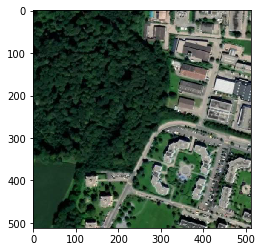

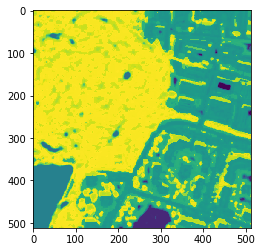

In [88]:
start_time = time.clock()
thumb_size = 512

def test_image(img):
    features = preprocess_img(img)
    return features
pil_img_obj = Image.open('TOLABEL16/original/4.jpeg')
pil_img_obj.thumbnail((thumb_size,thumb_size), Image.ANTIALIAS)
test_img = np.asarray(pil_img_obj)
preprocessed_test_img = test_image(test_img)

print("--- Elapsed %s seconds ---" % (time.clock() - start_time))

predicted_test_img = bdt.predict_proba(preprocessed_test_img)[:,1] # second column = prob of class = tree

print("--- Total %s seconds ---" % (time.clock() - start_time))

plt.imshow(test_img)
plt.figure()
plt.imshow(predicted_test_img.reshape(thumb_size, thumb_size))
print('Predicted!')

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


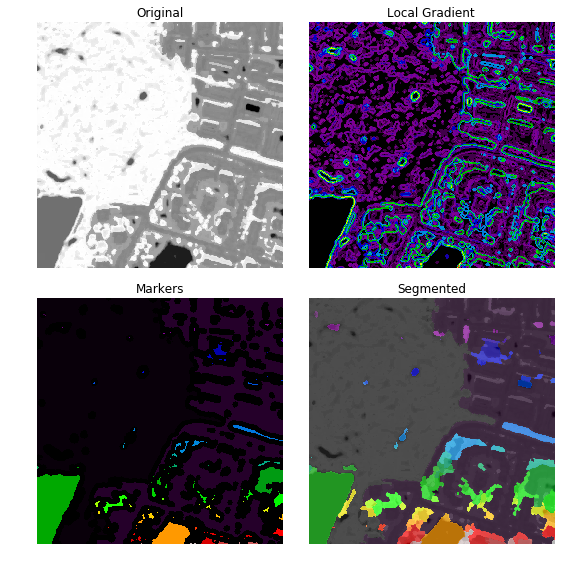

In [89]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, watershed
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.filters import rank
from scipy import ndimage as ndi

predicted_reshaped_image = predicted_test_img.reshape(thumb_size, thumb_size)

markers = rank.gradient(predicted_reshaped_image, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(predicted_reshaped_image, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(predicted_reshaped_image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title("Markers")

ax[3].imshow(predicted_reshaped_image, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

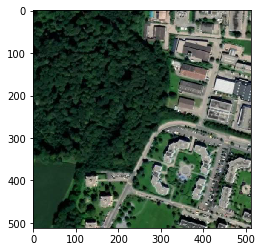

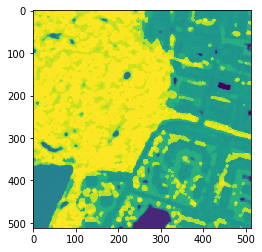

In [90]:
predicted_reshaped_image = predicted_test_img.reshape(thumb_size, thumb_size)
filtered_img = opening(predicted_reshaped_image, disk(3))
plt.imshow(test_img)
plt.figure()
plt.imshow(filtered_img)

Percentage of trees in picture = 43.2297%


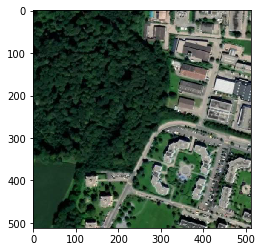

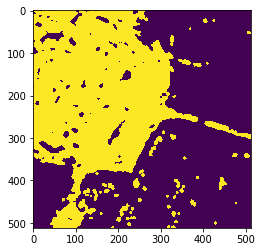

In [92]:
# filtered_img_255 = (filtered_img * 255).astype(int)
# thresh = cv2.adaptiveThreshold(filtered_img_255,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
ret,thresh = cv2.threshold(filtered_img,0.5,1,cv2.THRESH_BINARY)
plt.imshow(test_img)
plt.figure()
plt.imshow(thresh)

print('Percentage of trees in picture = {:6.4f}%'.format(np.count_nonzero(thresh) / thresh.size * 100))